In [2]:
import torch
import numpy
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
def Cliff2():
    """
    Random 2-qubit Clifford circuit.

    Arguments:
        -nodes (np.ndarray): 
    
    Returns:
        -null
    """
    
    weights = np.random.randint(2, size=(2, 10))
    
    return qml.matrix(qml.RandomLayers(weights=weights,wires=[0,1])).numpy()

In [4]:
def RandomLayers(N_QUBITS, DEPTH):
    """
    Generates brick wall pattern of random 2 qubit Clifford gates

    Arguments:
        -N_QUBITS (int): Number of qubits
        -DEPTH (int): Depth of the circuit

    Returns:
        -random_layers (np.ndarray): Array of 4x4 unitaries (N_QUBITS, DEPTH, 4, 4)
    
    """

    random_layers = []
    for t in range(DEPTH):
        layer = []
        for x in range(0,N_QUBITS,2):
                layer.append(Cliff2())
        random_layers.append(layer)

    return random_layers


In [38]:
N_QUBITS = 2*2
DEPTH = 2

# random_layers = []
# # for t in range(DEPTH):
# #         layer = []
# #         for x in range(0,N_QUBITS,2):
# #                 layer.append(Cliff2())
# #         random_layers.append(layer)

random_layers = RandomLayers(N_QUBITS,DEPTH)

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def circuit(theta,random_layers):
    """
    Quantum circuit with random entangling Clifford layers and disentangling layers.
    
    Arguments:
        -theta (np.ndarray): Binary matrix representing the positions of projections. (N_QUBITS, DEPTH)
    
    Returns:
        -Average Von Neumann entropy (float32): Average of 2-qubit Von Neumann entropies over all neighbors.
    """

    theta = theta.T
    DEPTH,N_QUBITS = np.shape(theta)

    for t in range(DEPTH):
        layer = random_layers[t]
        if t%2==0:
            for x in range(0,N_QUBITS,2):
                brick = layer[int(x/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
        elif t%2==1:
            for x in range(1,N_QUBITS-2,2):
                brick = layer[int((x-1)/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
            brick = layer[-1]
            qml.QubitUnitary(brick,wires=[N_QUBITS-1,0])
            
        projections = theta[t]
        for x in range(N_QUBITS):
            if projections[x]==1:
                qml.Projector(state=[0],wires=[x])
            
    entropies = []
    for x in range(N_QUBITS-1):
        entropies.append(qml.vn_entropy(wires=[x,x+1]))
    entropies.append(qml.vn_entropy(wires=[N_QUBITS-1,0]))
        
    return entropies

In [39]:
random_layers[1][0]

array([[-0.05322247+0.72263952j,  0.2995274 +0.30642316j,
        -0.43878722+0.22929549j,  0.17551082-0.12422954j],
       [-0.18525643+0.13197336j,  0.25940413-0.60535276j,
        -0.37718776-0.18931806j, -0.54936973+0.18601504j],
       [ 0.02589789-0.49440869j, -0.18599988+0.10789381j,
        -0.63494589+0.3491192j , -0.15398241-0.39987653j],
       [-0.32911192-0.26419175j,  0.39776147-0.42213091j,
        -0.04290916+0.22337349j,  0.65839591+0.01604013j]])

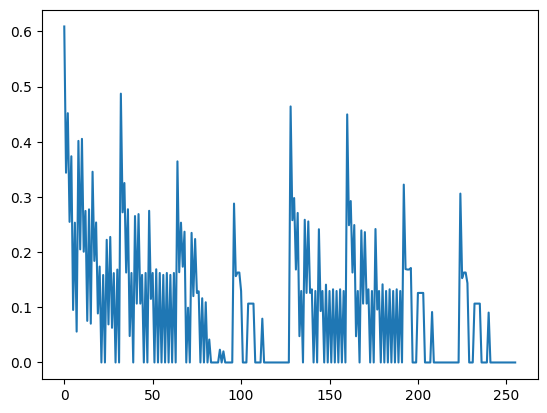

In [40]:
def all_binary_matrices(n, m):
    # Total number of binary matrices possible
    total_matrices = 2 ** (n * m)
    
    # Generate all binary matrices
    matrices = []
    for i in range(total_matrices):
        # Convert i to binary and pad with zeros
        binary_string = format(i, f'0{n*m}b')
        
        # Convert binary string to numpy array and reshape to (n, m)
        matrix = np.array([int(bit) for bit in binary_string]).reshape((n, m))
        matrices.append(matrix)
    
    return np.array(matrices)

x = all_binary_matrices(N_QUBITS,DEPTH)
Y = np.zeros(2**(N_QUBITS*DEPTH))
N = 100
for _ in range(N):
    random_layers = RandomLayers(N_QUBITS,DEPTH)
    y = [np.mean(circuit(theta,random_layers)) for theta in x]
    Y += y
Y = Y/N
plt.plot(Y)

In [67]:
min(Y)

tensor(-1.33226763e-17, requires_grad=True)

In [43]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
random_layers = RandomLayers(N_QUBITS,DEPTH)

circuit(theta,random_layers)
drawer = qml.draw(circuit)
print(drawer(theta,random_layers))

0: ─╭U(M0)─────────╭U(M3)──|0⟩⟨0|─┤ ╭vnentropy                       ╭vnentropy
1: ─╰U(M0)─╭U(M2)──│──────────────┤ ╰vnentropy ╭vnentropy            │         
2: ─╭U(M1)─╰U(M2)──│───────|0⟩⟨0|─┤            ╰vnentropy ╭vnentropy │         
3: ─╰U(M1)──|0⟩⟨0|─╰U(M3)──|0⟩⟨0|─┤                       ╰vnentropy ╰vnentropy

M0 = 
[[ 0.55107649-0.3095665j  -0.14881107-0.15223301j -0.56696625+0.33818396j
  -0.32193385-0.12531214j]
 [ 0.32193385+0.12531214j  0.75806723-0.14268858j  0.14881107+0.15223301j
  -0.13765379+0.47049051j]
 [-0.51742924-0.36035825j  0.27239684-0.08316527j -0.53683854-0.38671583j
  -0.17587326+0.22938234j]
 [ 0.17587326-0.22938234j  0.18703054+0.49351545j -0.27239684+0.08316527j
   0.74328309+0.06578884j]]
M1 = 
[[ 0.46352924+0.08859602j -0.00920938+0.07173692j -0.81260535+0.05341353j
   0.09525886+0.31592038j]
 [-0.30443427-0.03046805j  0.08880891-0.81888024j -0.08322303+0.11651754j
  -0.10783024+0.44250405j]
 [-0.07362164-0.69861549j -0.52457742+0.05826816j -0.1563070

In [44]:
def loss(theta, random_layers,alpha=0.01, beta=5.0):
    entropy = np.mean(circuit(theta,random_layers))
    budget = alpha*np.mean(np.ndarray.flatten(theta))
    final_layer = beta*np.mean(theta[:,-1])
    
    return entropy+budget

In [46]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
loss(theta,random_layers)

tensor(0.0075, requires_grad=True)

In [52]:
def grad(theta,random_layers):
    grads = np.zeros(np.shape(theta))

    for i in range(np.shape(theta)[0]):
        for j in range(np.shape(theta)[1]):
            h = np.zeros(np.shape(theta))
            h[i][j] = 1
            theta_prime = (theta+h)%2
            grads[i][j] = loss(theta_prime,random_layers) - loss(theta,random_layers)
    
    return grads
    

In [61]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
random_layers = RandomLayers(N_QUBITS,DEPTH)
grad(theta,random_layers)

tensor([[ 0.00125   ,  0.05889314],
        [ 0.00125   ,  0.00125   ],
        [ 0.00125   ,  0.09812121],
        [-0.00125   ,  0.10082655]], requires_grad=True)

In [62]:
np.unravel_index(np.argmin(grad(theta,random_layers)), shape=np.shape(theta))

(3, 0)

In [70]:
def main():
    n_training = 10
    random_layers = RandomLayers(N_QUBITS,DEPTH)
    theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
    for step in range(n_training):
        l = loss(theta,random_layers)
        entropy = np.mean(circuit(theta,random_layers))
        g = grad(theta,random_layers)
        dir = np.unravel_index(np.argmin(grad(theta,random_layers)), shape=np.shape(theta))
        h = np.zeros(np.shape(theta))
        h[dir[0]][dir[1]] = 1
        theta = (theta+h)%2


    return theta, l, entropy


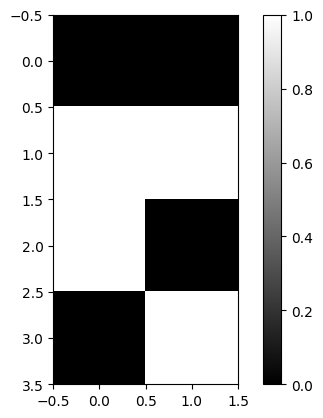


 Loss: 0.0037500000000005116, 


In [84]:
theta, l, entropy = main()
plt.imshow(theta, cmap="gray")
plt.colorbar()
plt.show()
print("\n Loss: {}, \n Averaged von Neumann entropy: {}".format(l, entropy), end="\r")

In [69]:
epochs = 10
thetas = []
losses = []
for epoch in range(epochs):
    theta, l = main()
    thetas.append(theta)
    losses.append(l)

    print("\n Epoch: {}, Loss: {}".format(epoch+1, l), end="\r")


 Epoch: 1, Loss: 0.0037499999999998333
 Epoch: 2, Loss: 0.0037500000000001664
 Epoch: 3, Loss: 0.0049999999999998344
 Epoch: 4, Loss: 0.004999999999999778
 Epoch: 5, Loss: 0.0037500000000001863
 Epoch: 6, Loss: 0.003750000000000442
 Epoch: 7, Loss: 0.003749999999999778
 Epoch: 8, Loss: 0.0037499999999998286
 Epoch: 9, Loss: 0.003749999999999778


In [ ]:
for theta in thetas:
    print(circuit(theta,random_layers))

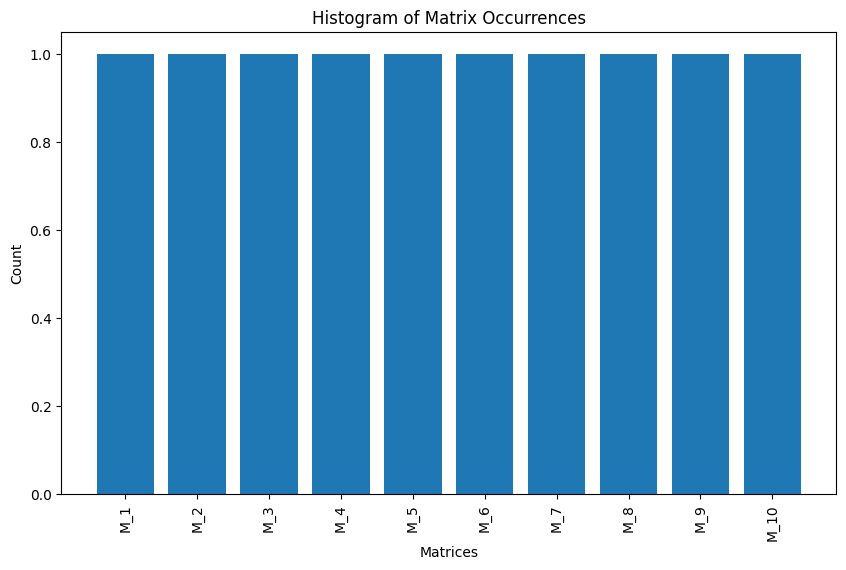

In [184]:
hashable_matrices = [tuple(map(tuple, matrix)) for matrix in thetas]

matrix_counts = Counter(hashable_matrices)

labels, counts = zip(*matrix_counts.items())

labels = [np.array(label) for label in labels]

plt.figure(figsize=(10,6))
plt.bar(range(len(counts)), counts, tick_label=["M_"+str(i+1) for i in range(len(labels))])
plt.xlabel('Matrices')
plt.ylabel('Count')
plt.title('Histogram of Matrix Occurrences')
plt.xticks(rotation=90)
plt.show()